In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re


In [ ]:
logs = pd.read_csv("/content/HDFS_2k.log", header=None)
logs.columns = ["log"]

print("Total log lines:", len(logs))
logs.head()


Total log lines: 2000


,log
0,081109 203615 148 INFO dfs.DataNode$PacketResp...
1,081109 203807 222 INFO dfs.DataNode$PacketResp...
2,081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...
3,081109 204015 308 INFO dfs.DataNode$PacketResp...
4,081109 204106 329 INFO dfs.DataNode$PacketResp...


In [ ]:
def extract_block_id(line):
    match = re.search(r'(blk_-?\d+)', line)
    return match.group(1) if match else None

logs["block_id"] = logs["log"].apply(extract_block_id)
logs = logs.dropna(subset=["block_id"])

logs.head()


,log,block_id
0,081109 203615 148 INFO dfs.DataNode$PacketResp...,blk_38865049064139660
1,081109 203807 222 INFO dfs.DataNode$PacketResp...,blk_-6952295868487656571
2,081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...,blk_7128370237687728475
3,081109 204015 308 INFO dfs.DataNode$PacketResp...,blk_8229193803249955061
4,081109 204106 329 INFO dfs.DataNode$PacketResp...,blk_-6670958622368987959


In [ ]:
def clean_log(line):
    line = re.sub(r'\d+', '', line)
    line = re.sub(r'blk_-?\d+', 'BLK', line)
    return line.lower()

logs["clean_log"] = logs["log"].apply(clean_log)
logs.head()


,log,block_id,clean_log
0,081109 203615 148 INFO dfs.DataNode$PacketResp...,blk_38865049064139660,info dfs.datanode$packetresponder: packetre...
1,081109 203807 222 INFO dfs.DataNode$PacketResp...,blk_-6952295868487656571,info dfs.datanode$packetresponder: packetre...
2,081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...,blk_7128370237687728475,info dfs.fsnamesystem: block* namesystem.ad...
3,081109 204015 308 INFO dfs.DataNode$PacketResp...,blk_8229193803249955061,info dfs.datanode$packetresponder: packetre...
4,081109 204106 329 INFO dfs.DataNode$PacketResp...,blk_-6670958622368987959,info dfs.datanode$packetresponder: packetre...


In [ ]:
grouped_logs = logs.groupby("block_id")["clean_log"] \
                   .apply(lambda x: " ".join(x)) \
                   .reset_index()

print("Total blocks:", len(grouped_logs))
grouped_logs.head()


Total blocks: 1994


,block_id,clean_log
0,blk_-1030832046197982436,info dfs.fsnamesystem: block* namesystem.de...
1,blk_-1046472716157313227,info dfs.fsdataset: deleting block blk_- fi...
2,blk_-1049340855430710153,info dfs.datanode$packetresponder: packetre...
3,blk_-1055254430948037872,info dfs.fsnamesystem: block* namesystem.ad...
4,blk_-1067234447809438340,info dfs.datanode$packetresponder: packetre...


In [ ]:
labels = pd.read_csv("/content/anomaly_label.csv")
labels.columns = ["block_id", "label"]

labels["label"].value_counts()


,count
label,
Normal,558223
Anomaly,16838


In [ ]:
data = grouped_logs.merge(labels, on="block_id", how="inner")

print("Final dataset size:", len(data))
data.head()


Final dataset size: 1994


,block_id,clean_log,label
0,blk_-1030832046197982436,info dfs.fsnamesystem: block* namesystem.de...,Normal
1,blk_-1046472716157313227,info dfs.fsdataset: deleting block blk_- fi...,Normal
2,blk_-1049340855430710153,info dfs.datanode$packetresponder: packetre...,Normal
3,blk_-1055254430948037872,info dfs.fsnamesystem: block* namesystem.ad...,Normal
4,blk_-1067234447809438340,info dfs.datanode$packetresponder: packetre...,Normal


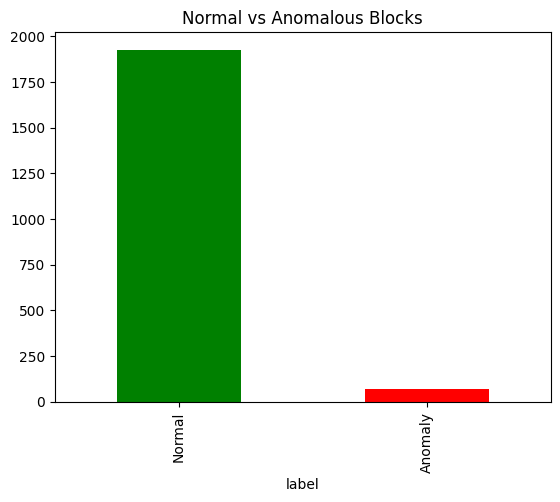

In [ ]:
data["label"].value_counts().plot(
    kind="bar",
    title="Normal vs Anomalous Blocks",
    color=["green", "red"]
)
plt.show()


In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs("data/processed", exist_ok=True)

data.to_csv("data/processed/cleaned_labeled_logs.csv", index=False)
print("✅ Processed data saved successfully")

✅ Processed data saved successfully
